# Importações

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
import scipy.stats as stats
from google.colab import drive
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve

from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Carregando base

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Neurotech - Cientista de Dados III/challenge-data-scientist/datasets/credit_01/train.gz")
df_test = pd.read_csv("/content/drive/MyDrive/Neurotech - Cientista de Dados III/challenge-data-scientist/datasets/credit_01/test.gz")
df_oot = pd.read_csv("/content/drive/MyDrive/Neurotech - Cientista de Dados III/challenge-data-scientist/datasets/credit_01/oot.gz")

# Entendimento da base de dados

In [ ]:
df_train.head()

,REF_DATE,TARGET,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR20,VAR21,VAR22,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR31,VAR32,VAR33,VAR34,VAR35,VAR36,VAR37,VAR38,VAR39,VAR40,VAR41,VAR42,VAR43,VAR44,VAR45,VAR46,VAR47,VAR48,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,BAIXA,1.0,0.182,NaN,0.141,NaN,0.416667,NaN,1.263014,NaN,NaN,NaN,NaN,NaN,0.034,NaN,NaN,NaN,0.0,NaN,0.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512334,0.486768,0.357526,0.538737,NaN,NaN,NaN,NaN,0.046,NaN,S,N,N,N,N,N,N,N,N,N,N,N,S,N,N,N,N,MEDIA,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA,ALTISSIMA,BAIXISSIMA,BAIXISSIMA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTISSIMA,ALTA,MEDIA,ALTA,MEDIA,ALTA,ALTISSIMA,ALTISSIMA,MEDIA,BAIXISSIMA,ALTISSIMA,MEDIA,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA,MEDIA,MEDIA,ALTA,BAIXISSIMA,ALTA,LONGE,LONGE,LONGE,PROXIMO,MEDIO,LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,LONGE,PROXIMO,MEDIO,PROXIMO,MUITO LONGE,LONGE,PROXIMO,MEDIO,PROXIMO,LONGE,MUITO LONGE,MEDIO,LONGE,LONGE,MEDIO,LONGE,MUITO LONGE,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,181755
1,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,MEDIA,0.0,NaN,NaN,0.136,0.127,NaN,NaN,0.654795,1.545205,NaN,NaN,0.125,NaN,0.017,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.328021,0.447454,0.414335,0.485512,NaN,NaN,NaN,NaN,0.099,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,ALTA,ALTISSIMA,ALTA,BAIXISSIMA,ALTA,ALTISSIMA,ALTA,MEDIA,ALTA,MEDIA,ALTISSIMA,MEDIA,MEDIA,ALTA,BAIXISSIMA,ALTA,ALTA,MEDIA,ALTISSIMA,ALTA,ALTA,ALTA,ALTA,MEDIA,BAIXISSIMA,ALTISSIMA,MEDIA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,MEDIA,MEDIO,LONGE,MEDIO,MUITO LONGE,PROXIMO,MEDIO,PROXIMO,MEDIO,MEDIO,MEDIO,LONGE,LONGE,LONGE,LONGE,PROXIMO,LONGE,PROXIMO,PROXIMO,MUITO LONGE,MEDIO,MEDIO,PROXIMO,PROXIMO,PROXIMO,LONGE,MEDIO,PROXIMO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,MEDIO,PROXIMO,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,287633
2,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,ALTISSIMA,NaN,0.095,NaN,0.152,NaN,0.166667,NaN,1.665753,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,S,124.0,NaN,0.627262,0.730539,0.916771,0.519726,NaN,NaN,NaN,NaN,1.000,NaN,S,N,N,N,N,N,N,S,N,N,N,N,N,N,S,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,ALTA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,PROXIMO,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,88015
3,2017-08-05 00:00:00+

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120750 entries, 0 to 120749
Columns: 151 entries, REF_DATE to ID
dtypes: float64(34), int64(3), object(114)
memory usage: 139.1+ MB


In [ ]:
print("Tamanho da base (linhas,colunas): ",df_train.shape)

print("\n")

print("Inicio da base: ",df_train.REF_DATE.min())
print("Fim da base: ",df_train.REF_DATE.max())

print("\n")

print("Clientes únicos: ",df_train.ID.nunique())
print("Clientes duplicados: ",df_train.ID.duplicated().sum())

Tamanho da base (linhas,colunas):  (120750, 151)


Inicio da base:  2017-01-02 00:00:00+00:00
Fim da base:  2017-08-31 00:00:00+00:00


Clientes únicos:  120750
Clientes duplicados:  0


In [ ]:
df_columns_more_null_or_nan = ((df_train.isna().sum() / df_train.shape[0] * 100).sort_values(ascending=False) > 60).reset_index().rename(columns={'index':'coluna',0:'nulo'}).query("nulo == True")
columns_more_null_or_nan = df_columns_more_null_or_nan.coluna.tolist()
print("Colunas com mais de 65% de valores nulos: ",len(columns_more_null_or_nan),'\n',columns_more_null_or_nan)

Colunas com mais de 65% de valores nulos:  29 
 ['VAR146', 'VAR4', 'VAR46', 'VAR45', 'VAR44', 'VAR43', 'VAR145', 'VAR38', 'VAR26', 'VAR27', 'VAR144', 'VAR143', 'VAR31', 'VAR48', 'VAR34', 'VAR33', 'VAR20', 'VAR30', 'VAR28', 'VAR13', 'VAR23', 'VAR17', 'VAR21', 'VAR29', 'VAR36', 'VAR37', 'VAR35', 'VAR32', 'VAR16']


In [ ]:
print("Balanceamento das classes:\n",df_train.TARGET.value_counts())

Balanceamento das classes:
 0    91163
1    29587
Name: TARGET, dtype: int64


# Análise exploratória

## Análise descritiva

### Variáveis continuas e inteiras

In [ ]:
df_train.describe()

,TARGET,VAR3,VAR6,VAR7,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR20,VAR21,VAR22,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR37,VAR39,VAR40,VAR41,VAR42,VAR44,VAR46,VAR47,VAR141,VAR145,VAR146,VAR147,ID
count,120750.000000,107040.000000,117394.000000,117394.000000,74488.000000,65724.000000,15530.000000,95197.000000,58269.000000,44981.000000,15530.000000,95197.000000,58269.000000,11353.000000,15593.000000,58329.000000,15530.000000,97285.000000,58269.000000,1008.000000,1042.000000,12719.000000,24724.000000,12719.000000,25044.000000,120679.000000,117466.000000,117811.000000,107048.000000,401.000000,294.000000,120750.000000,120750.000000,679.000000,168.000000,120750.000000,120750.000000
mean,0.245027,42.125255,-14.411389,-45.903480,0.235917,0.290241,0.313850,0.241245,0.185754,2.044374,2.132795,0.978085,1.244427,0.045492,0.349243,0.212624,0.087496,0.080060,0.061524,0.359200,0.018753,0.003905,0.145150,0.194422,150.346550,0.461353,0.531287,0.631175,0.504619,1691.738429,6984.218469,0.256543,1854.833006,4018.743785,1942.649762,101.841656,165324.864199
std,0.430105,15.198476,8.995077,7.529788,0.625609,0.308937,0.241229,0.262687,0.195320,3.170869,2.171140,0.496078,1.121771,0.123168,0.192981,0.176746,0.127580,0.139072,0.125769,0.230197,0.034943,0.037876,0.149858,0.161558,82.413855,0.144093,0.115968,0.222607,0.069614,2177.830516,4621.964093,0.406746,893.999792,3700.836248,3143.757850,0.540016,95488.442320
min,0.000000,18.014000,-33.521563,-72.900276,-4.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.002740,0.002740,0.002740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.049309,0.208688,0.000000,0.006658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,3.000000
25%,0.000000,30.057250,-22.842778,-49.903564,0.000000,0.055000,0.056000,0.105000,0.078000,0.250000,0.493151,0.503899,0.347735,0.000000,0.250000,0.125000,0.011000,0.000000,0.000000,0.167000,0.000000,0.000000,0.042000,0.125000,102.000000,0.363787,0.447559,0.440572,0.463579,642.000000,3888.995000,0.000000,1513.227400,1633.195000,0.000000,102.000000,82727.250000
50%,0.000000,39.867000,-13.010590,-46.574908,0.000000,0.159000,0.318000,0.140000,0.112000,0.833333,0.816438,1.052055,1.142466,0.011000,0.250000,0.125000,0.043000,0.034000,0.000000,0.333000,0.000000,0.000000,0.104000,0.125000,134.000000,0.462267,0.510023,0.542298,0.496036,769.000000,5386.310000,0.003000,1627.157652,3024.480000,935.120000,102.000000,165298.000000
75%,0.000000,52.997000,-6.357067,-39.023621,0.000000,0.505000,0.507000,0.168000,0.153000,2.416667,4.079452,1.394521,1.463014,0.033000,0.500000,0.250000,0.096000,0.086000,0.065000,0.500000,0.033000,0.000000,0.188000,0.250000,182.000000,0.558495,0.582701,0.898052,0.522576,1747.500000,9601.390000,0.421000,1820.670284,5217.670000,2260.125000,102.000000,248248.000000
max,1.000000,105.477000,4.602823,-32.429516,4.000000,1.500000,1.000000,1.700000,1.000000,15.999999,8.999999,2.471023,7.406250,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.367000,1.000000,1.000000,1.000000,902.000000,0.953539,0.920685,1.000000,0.910865,17374.940000,26523.920000,1.000000,33954.140000,33954.140000,17229.200000,102.000000,330581.000000


<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


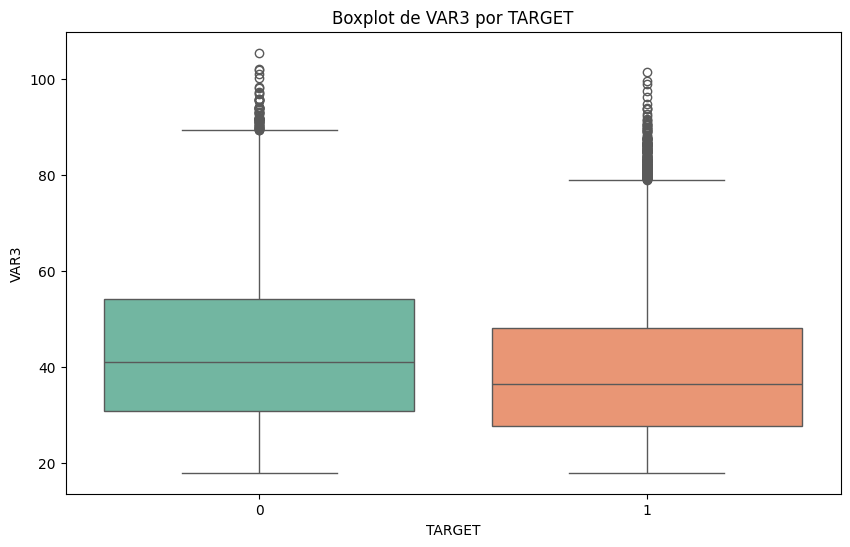

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


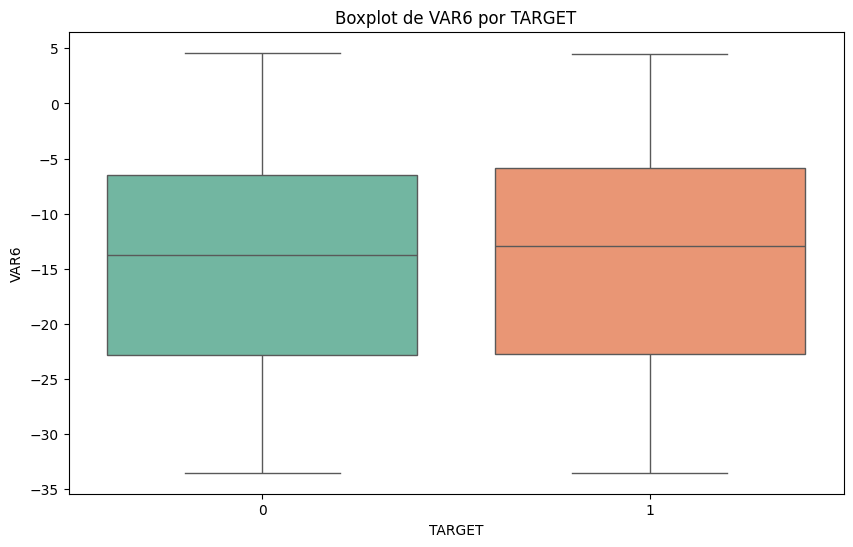

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


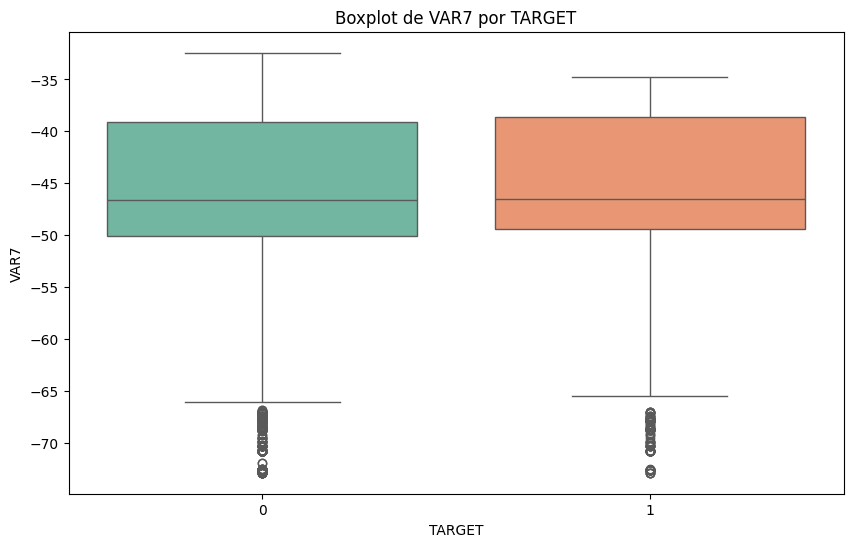

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


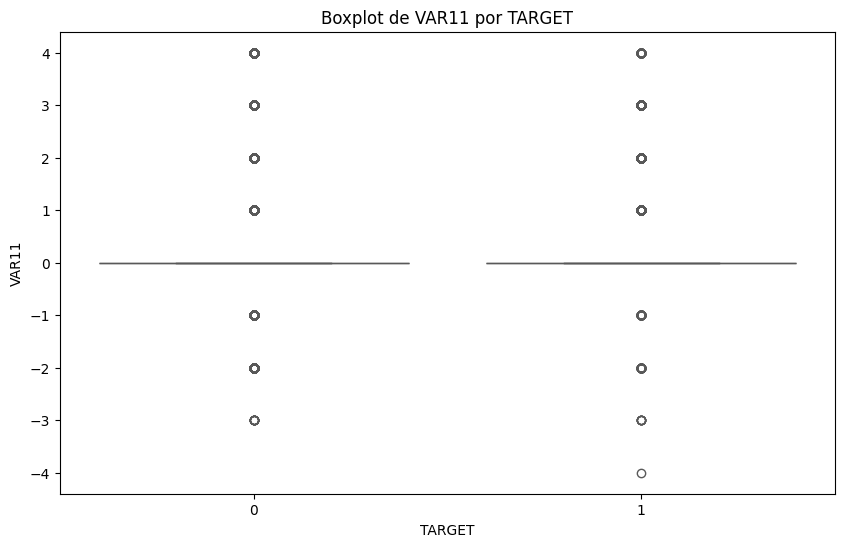

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


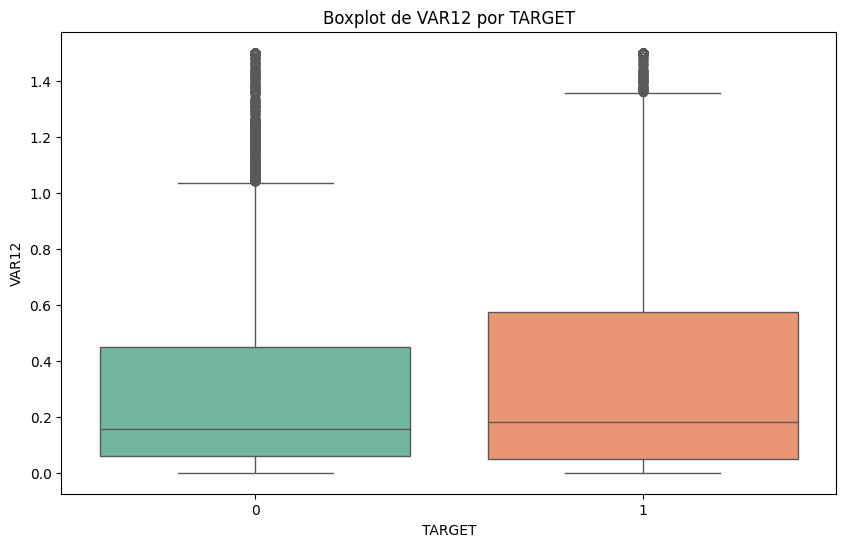

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


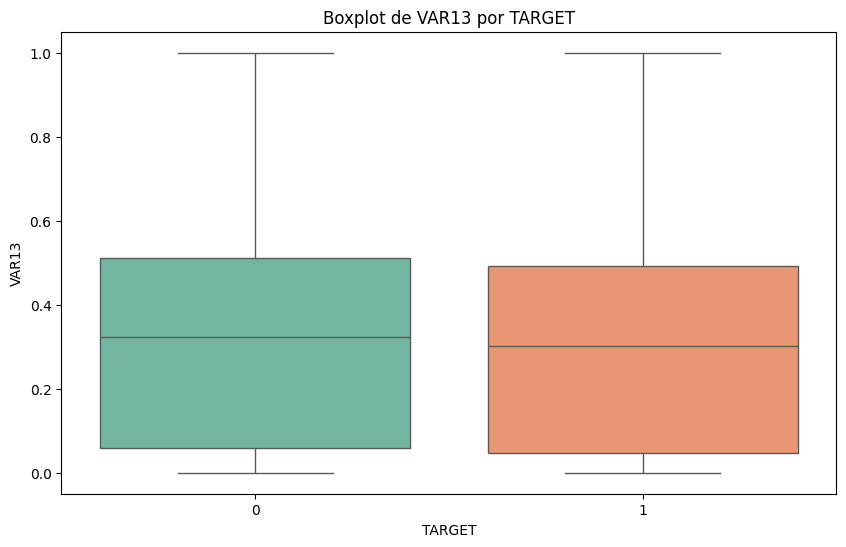

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


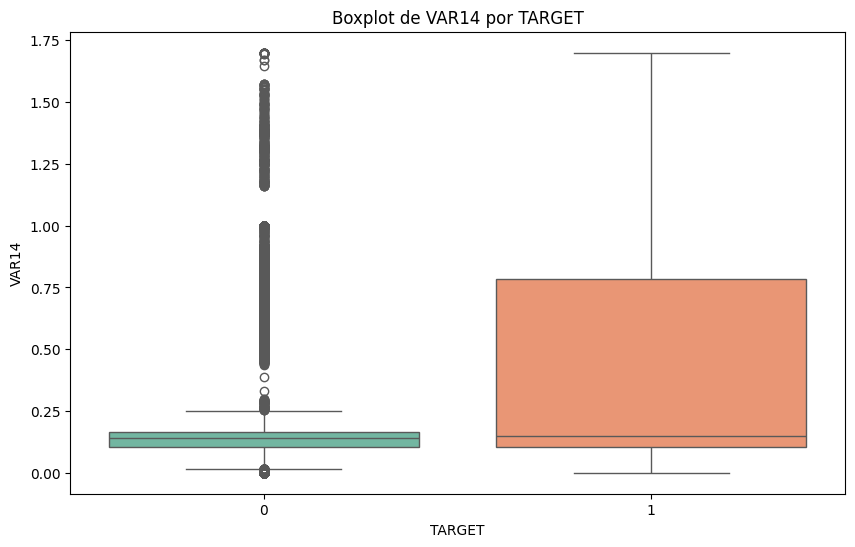

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


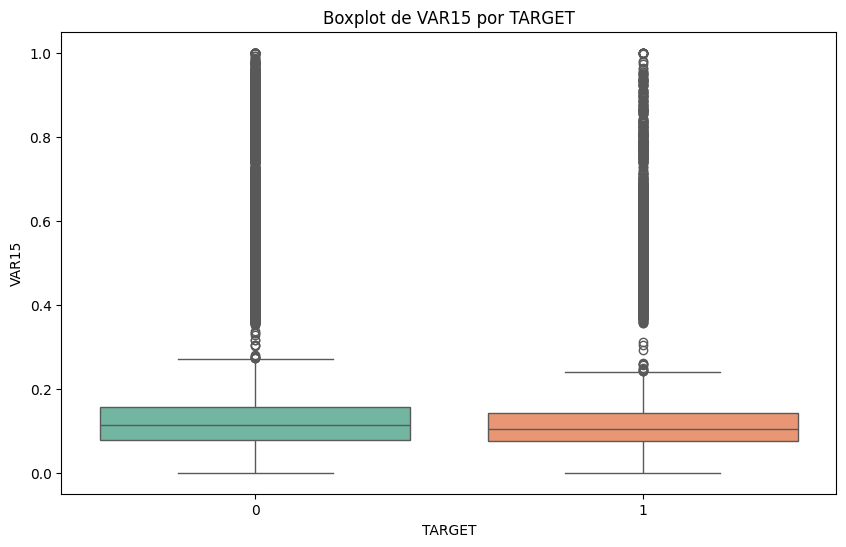

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


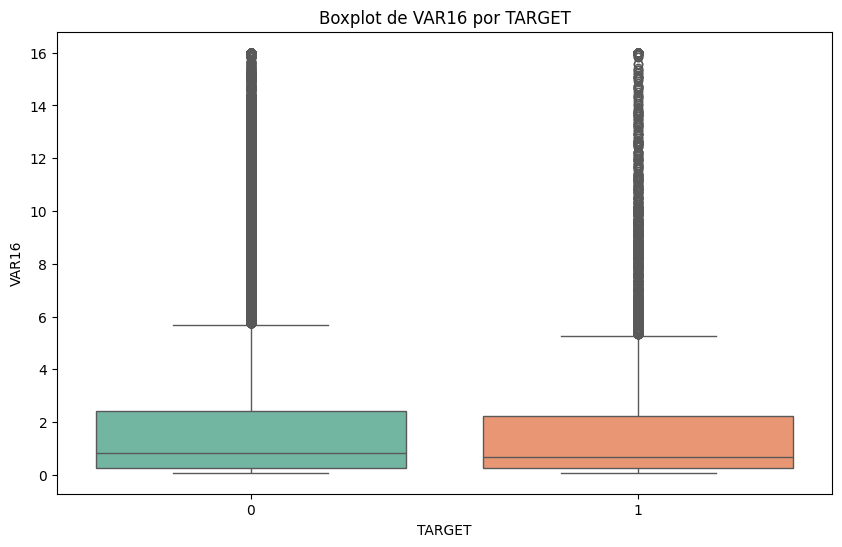

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


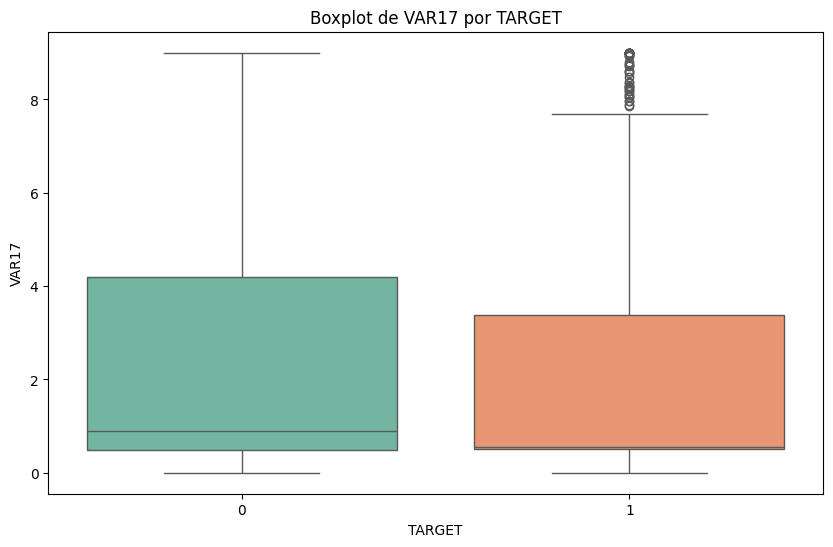

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


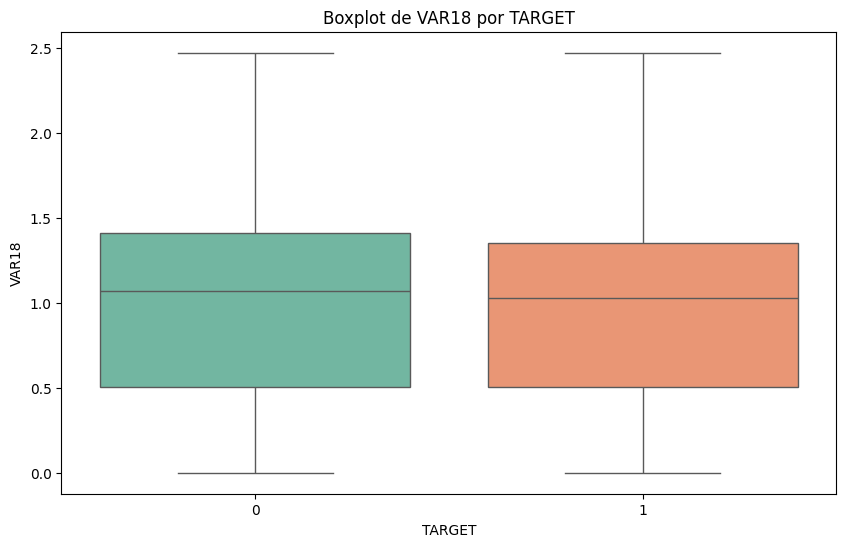

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


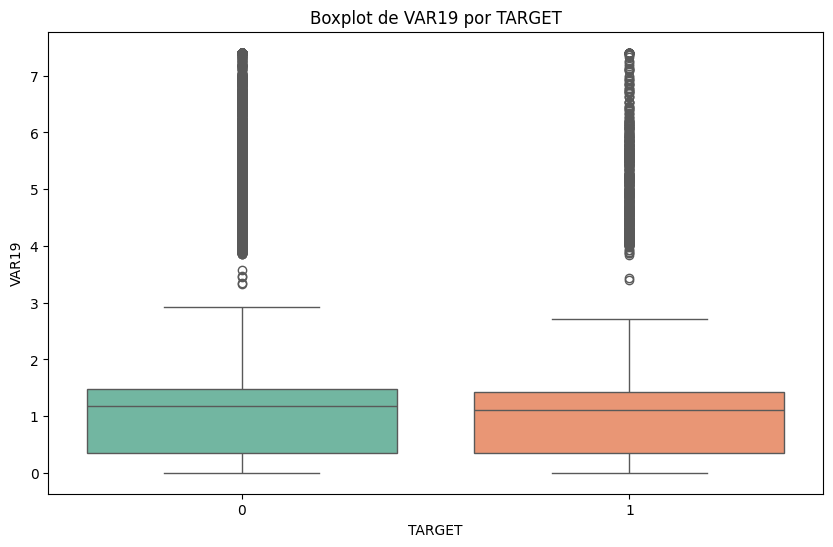

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


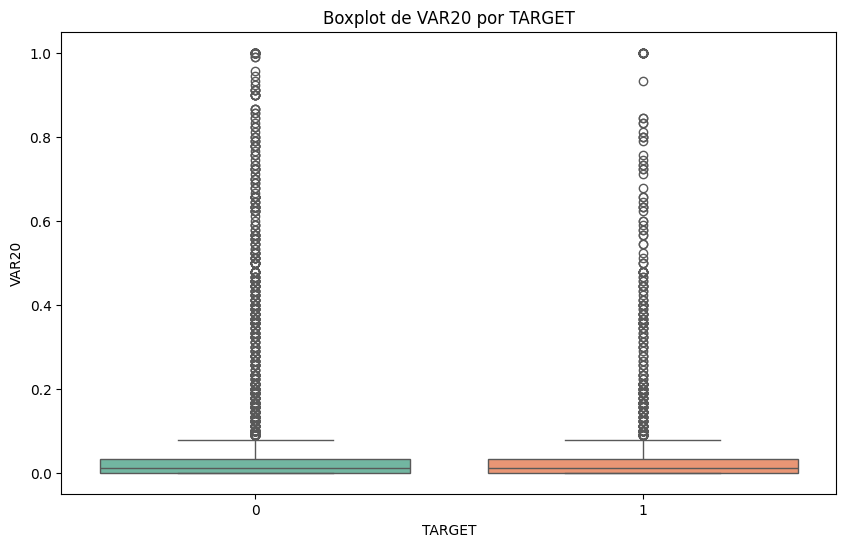

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


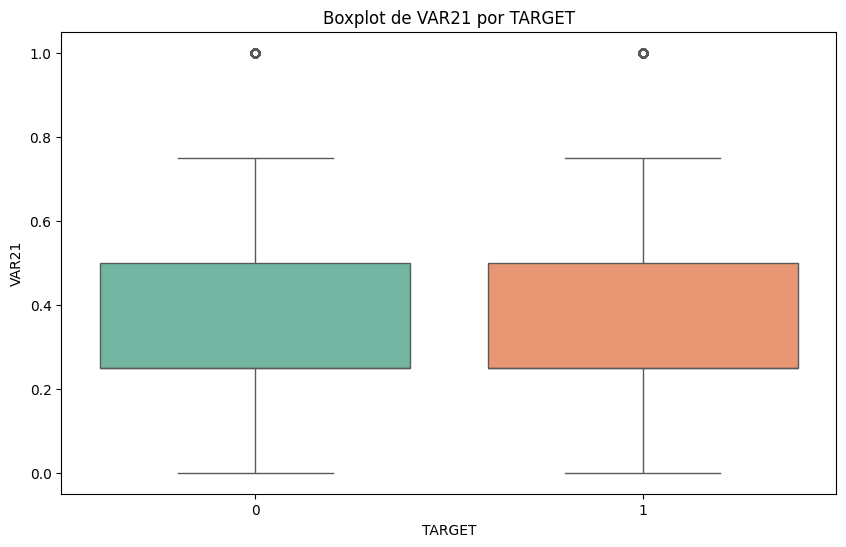

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


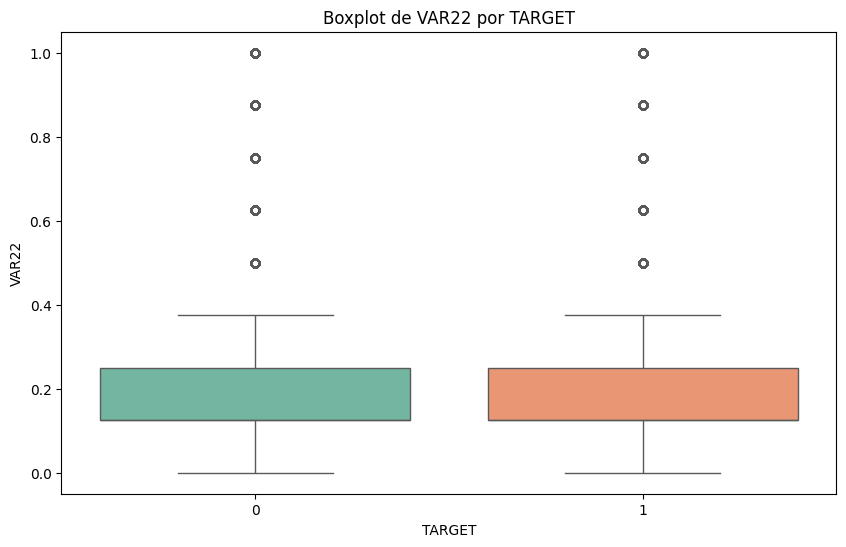

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


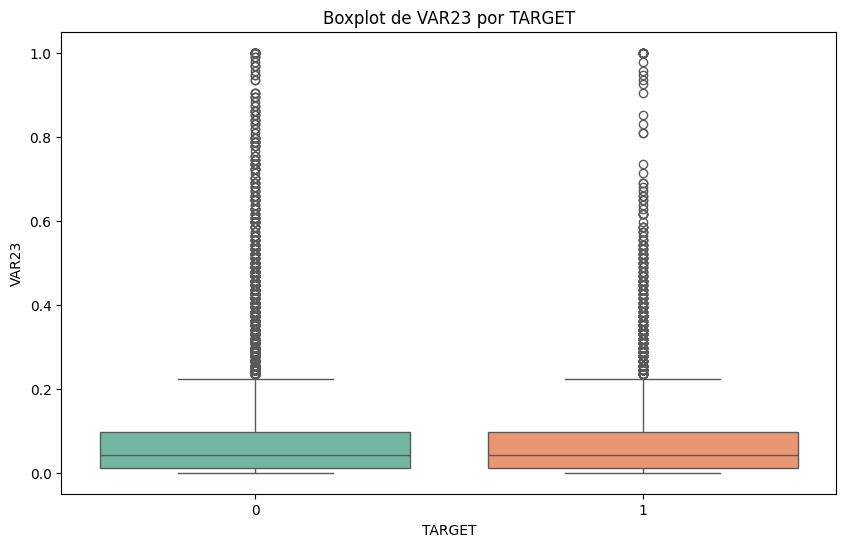

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


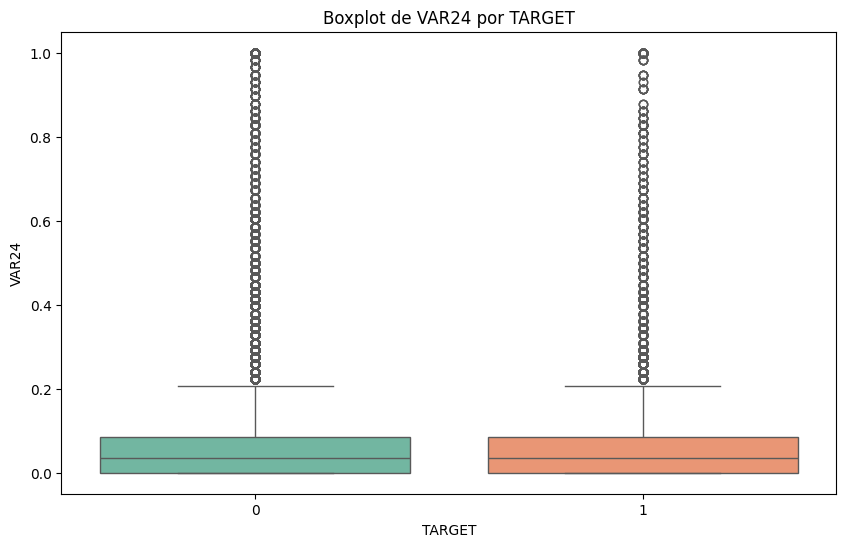

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


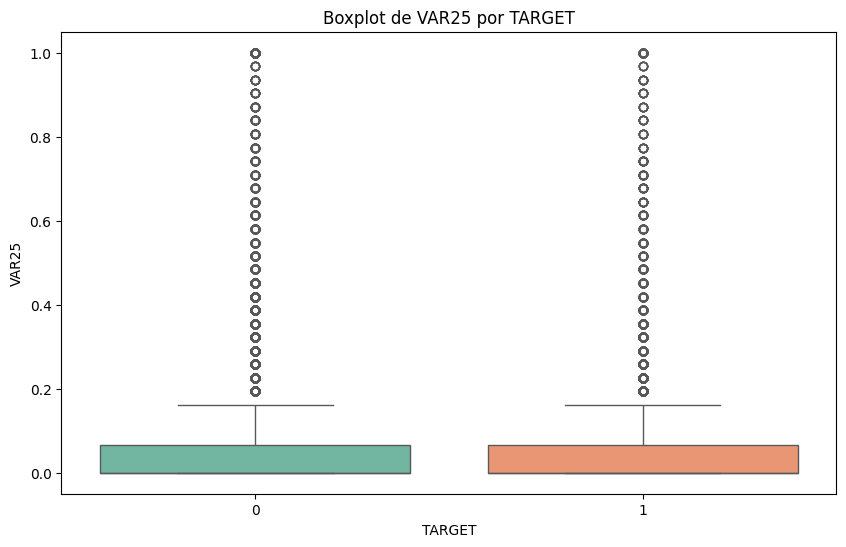

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


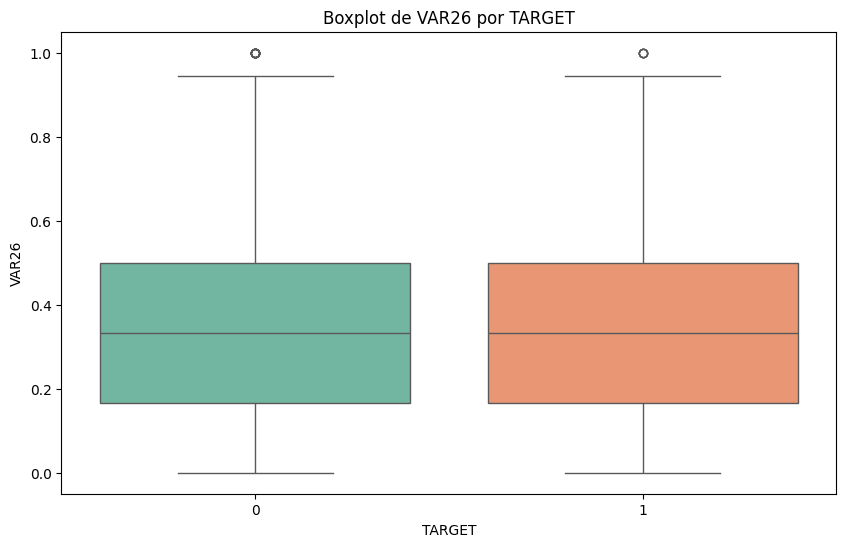

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


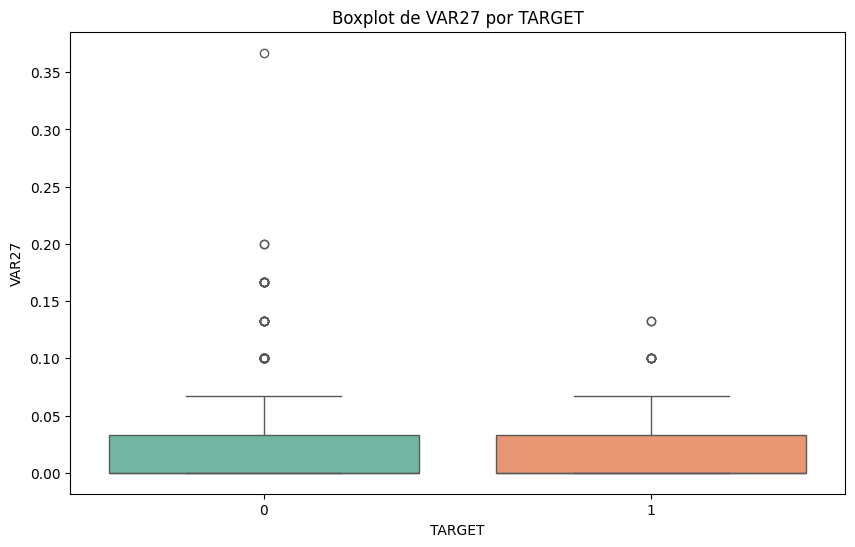

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


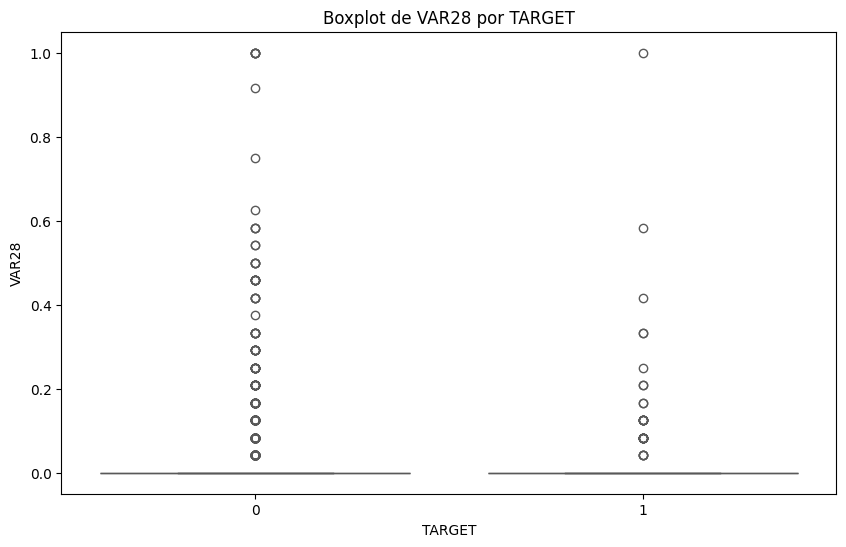

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


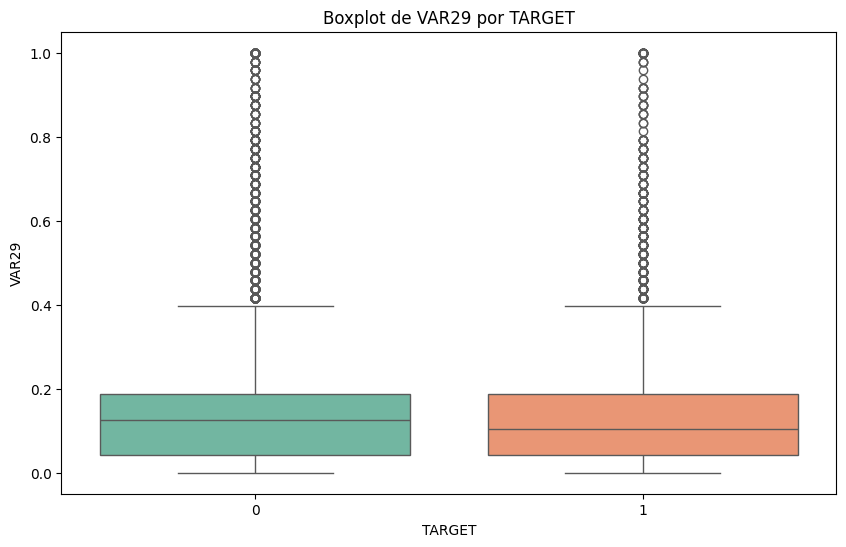

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


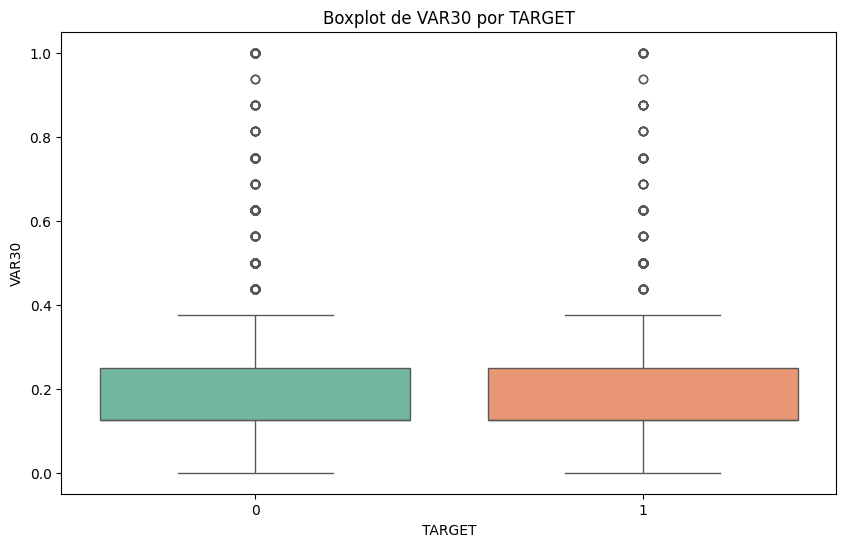

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


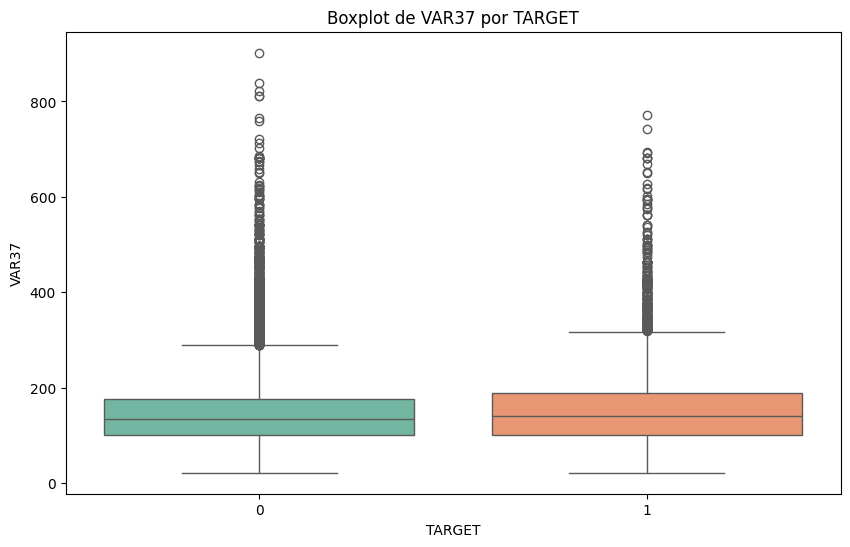

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


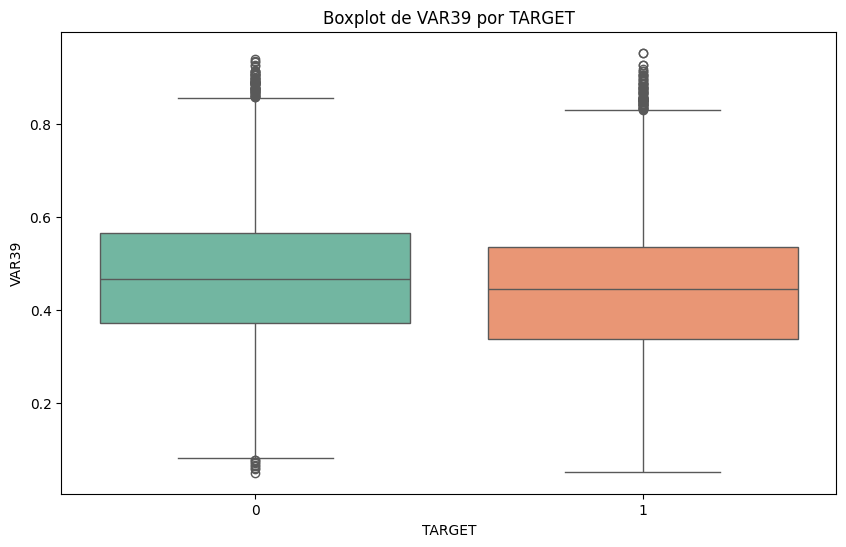

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


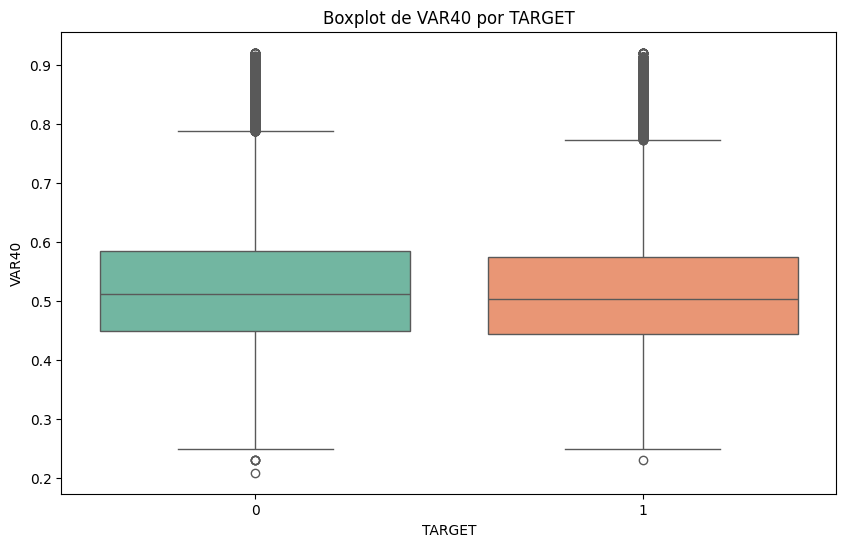

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


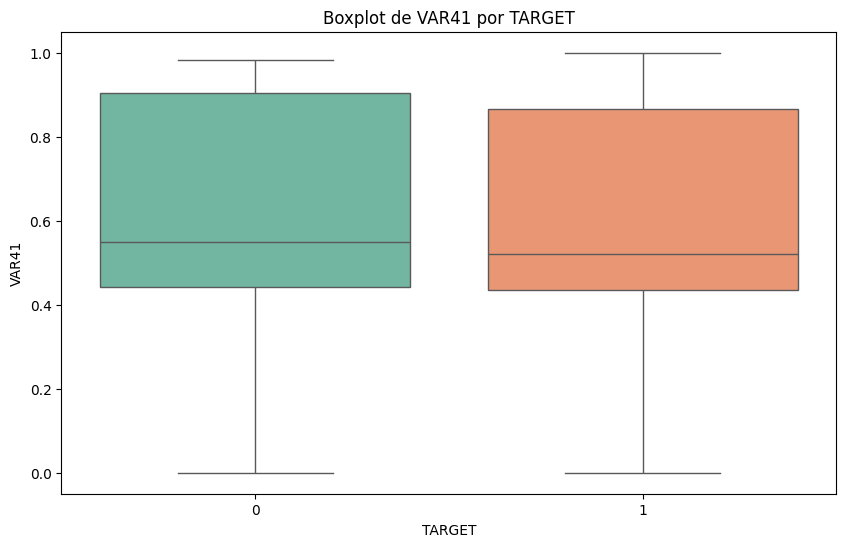

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


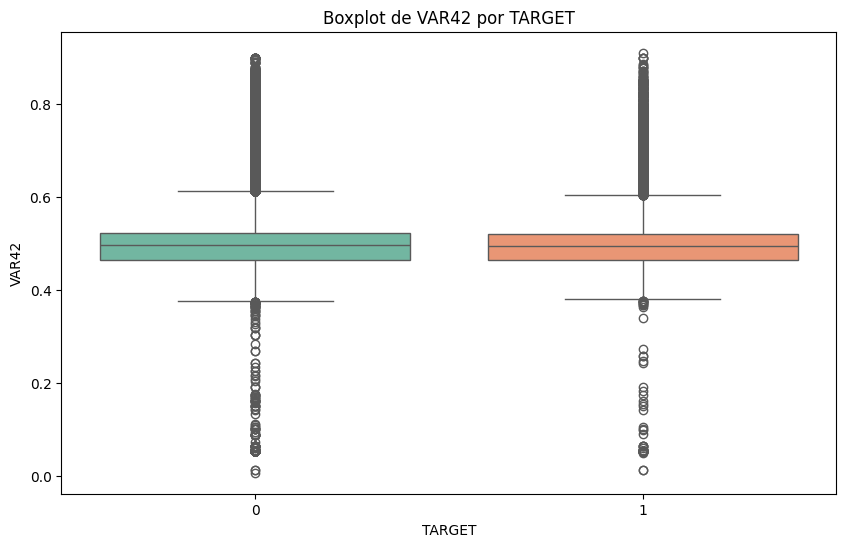

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


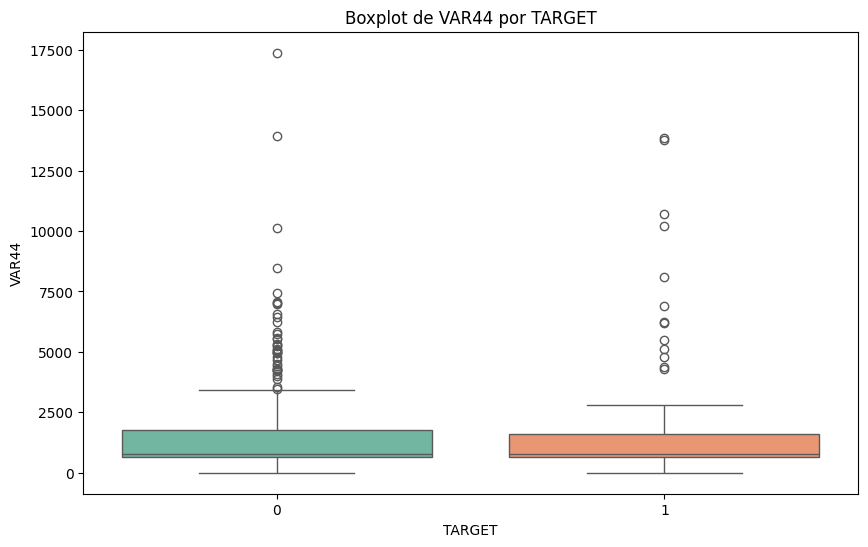

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


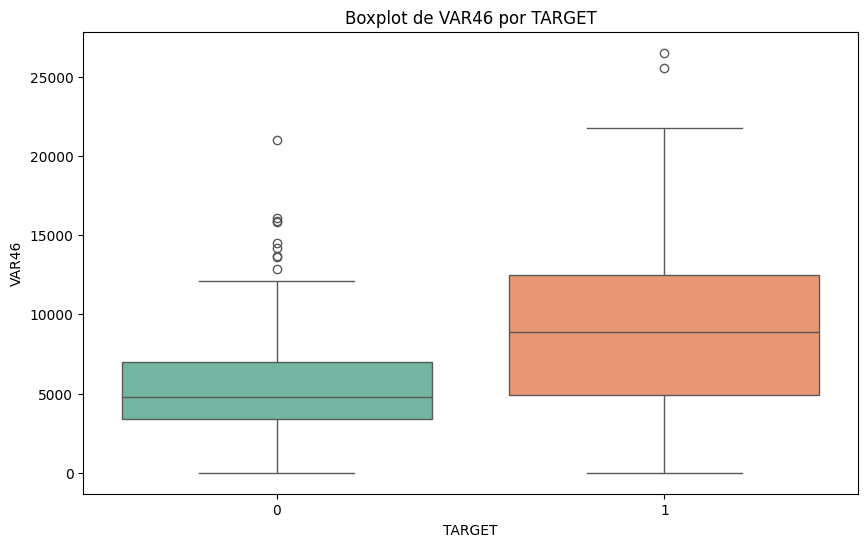

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


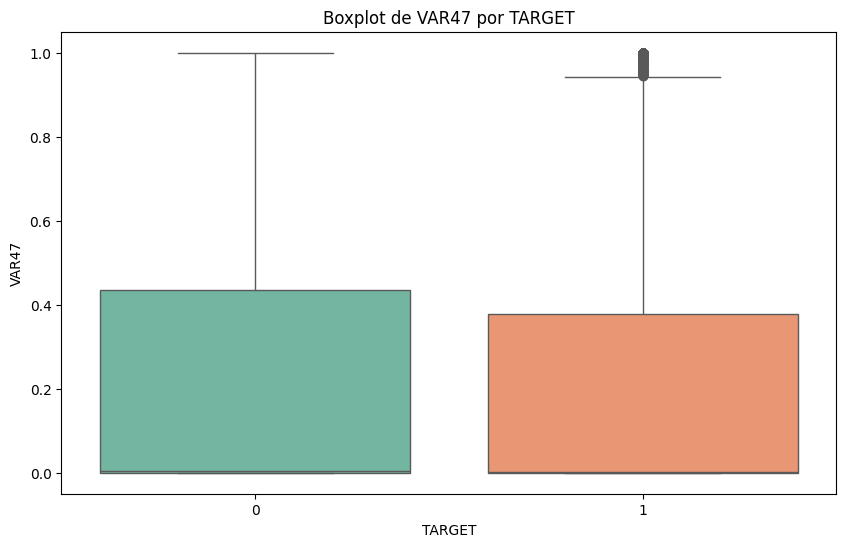

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


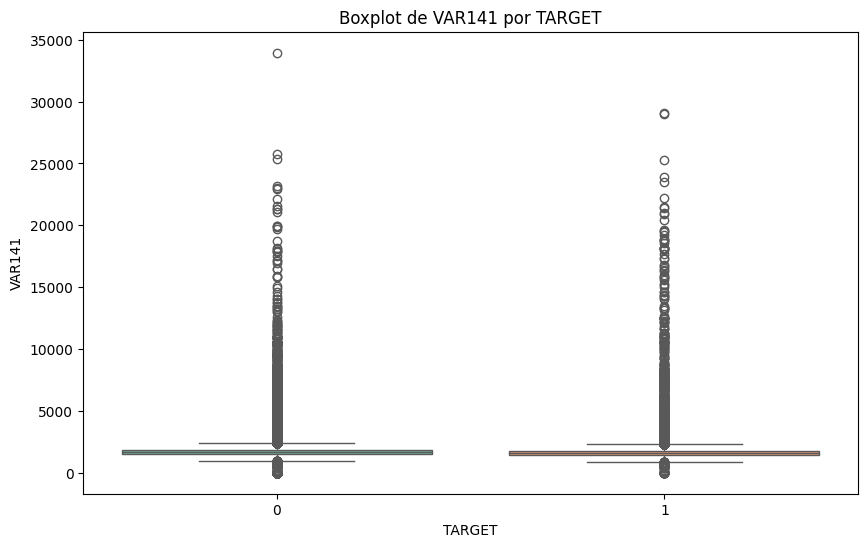

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


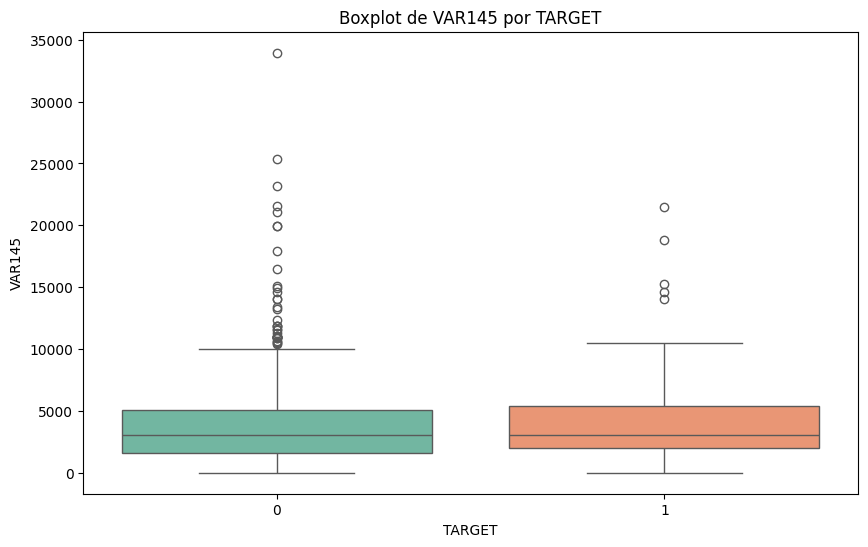

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


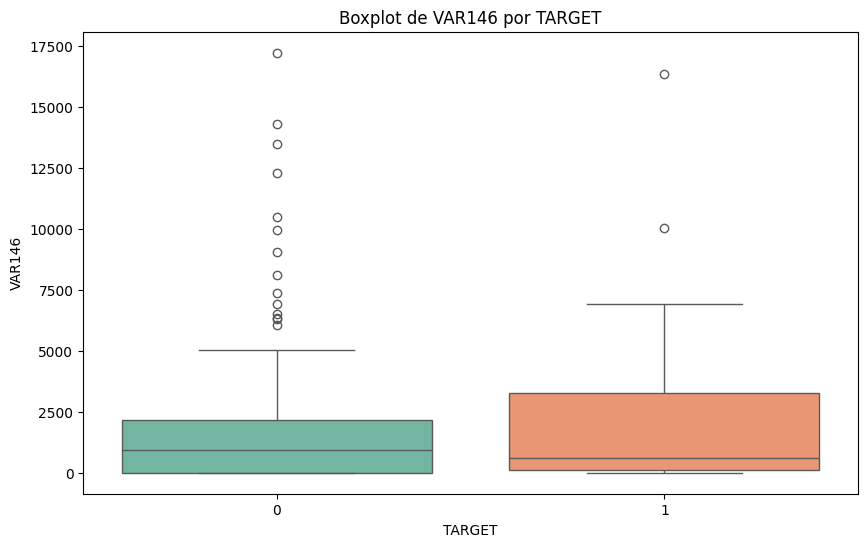

<ipython-input-10-fa1313d5f0be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")


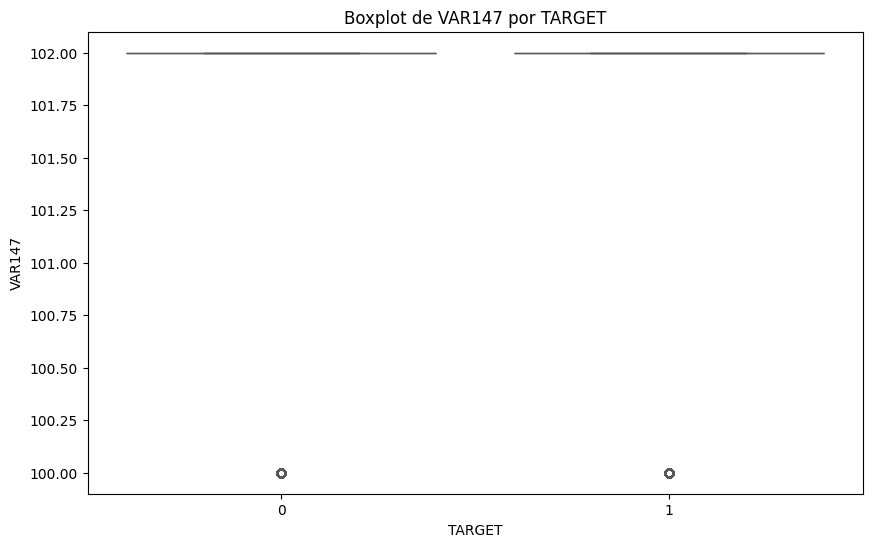

In [ ]:
colunas_para_comparar = df_train.describe().columns[1:-1]

for coluna in colunas_para_comparar:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='TARGET', y=coluna, data=df_train, palette="Set2")
    plt.title(f'Boxplot de {coluna} por TARGET')
    plt.show()

Através da analise descritiva visual utilizando o boxplot, concluise que as variáveis 3, 12, 14, 41 e 46, mostraram potencial diferença entre bons e maus pagadores.

In [ ]:
resultados = []
for coluna in tqdm(colunas_para_comparar):
    grupo0 = df_train[df_train['TARGET'] == 0][coluna]
    grupo1 = df_train[df_train['TARGET'] == 1][coluna]

    grupo0 = grupo0.dropna()
    grupo1 = grupo1.dropna()

    t_stat, p_val = stats.ttest_ind(grupo0, grupo1, equal_var=False)

    significancia = "Sim" if p_val < 0.05 else "Não"
    resultados.append((coluna, t_stat, p_val, significancia))

colunas_numericas_a_utilizar = []
for resultado in resultados:
    coluna, t_stat, p_val, significancia = resultado
    if significancia == 'Sim':
      print(f"Coluna: {coluna}, t-Statistic: {t_stat:.2f}, p-Value: {p_val:.4f}, Diferença Estatística Significativa: {significancia}")
      colunas_numericas_a_utilizar.append(coluna)

100%|██████████| 35/35 [00:05<00:00,  6.63it/s]

Coluna: VAR3, t-Statistic: 37.96, p-Value: 0.0000, Diferença Estatística Significativa: Sim
Coluna: VAR6, t-Statistic: -9.82, p-Value: 0.0000, Diferença Estatística Significativa: Sim
Coluna: VAR7, t-Statistic: -10.40, p-Value: 0.0000, Diferença Estatística Significativa: Sim
Coluna: VAR11, t-Statistic: 4.94, p-Value: 0.0000, Diferença Estatística Significativa: Sim
Coluna: VAR12, t-Statistic: -20.95, p-Value: 0.0000, Diferença Estatística Significativa: Sim
Coluna: VAR13, t-Statistic: 3.72, p-Value: 0.0002, Diferença Estatística Significativa: Sim
Coluna: VAR14, t-Statistic: -53.97, p-Value: 0.0000, Diferença Estatística Significativa: Sim
Coluna: VAR15, t-Statistic: 9.31, p-Value: 0.0000, Diferença Estatística Significativa: Sim
Coluna: VAR16, t-Statistic: 6.43, p-Value: 0.0000, Diferença Estatística Significativa: Sim
Coluna: VAR17, t-Statistic: 8.93, p-Value: 0.0000, Diferença Estatística Significativa: Sim
Coluna: VAR18, t-Statistic: 12.90, p-Value: 0.0000, Diferença Estatística S

Através do teste t de Student, percebemos que em relação a média, existem mais algumas variáveis do que as anteriormente citadas, com diferença estatística de média entre bons e maus pagadores.

### Variáveis categóricas

In [ ]:
colunas_categoricas = df_train.select_dtypes(include=['object']).columns[1:]

In [ ]:
for coluna in colunas_categoricas:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=coluna, hue='TARGET', data=df_train, palette='Set2')
    plt.title(f'Distribuição de {coluna} por TARGET')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
resultados = []
for coluna in tqdm(colunas_categoricas):
    tabela_cruzada = pd.crosstab(df_train[coluna], df_train['TARGET'])

    chi2, p_val, dof, expected = stats.chi2_contingency(tabela_cruzada)

    significancia = "Sim" if p_val < 0.05 else "Não"
    resultados.append((coluna, chi2, p_val, significancia))

colunas_categoricas_a_utilizar = []
for resultado in resultados:
    coluna, chi2, p_val, significancia = resultado
    if significancia == 'Sim':
      print(f"Coluna: {coluna}, Chi2-Statistic: {chi2:.2f}, p-Value: {p_val:.4f}, Associação Significativa: {significancia}")
      colunas_categoricas_a_utilizar.append(coluna)

100%|██████████| 113/113 [00:02<00:00, 45.46it/s]

Coluna: VAR2, Chi2-Statistic: 447.13, p-Value: 0.0000, Associação Significativa: Sim
Coluna: VAR5, Chi2-Statistic: 391.92, p-Value: 0.0000, Associação Significativa: Sim
Coluna: VAR8, Chi2-Statistic: 122.83, p-Value: 0.0000, Associação Significativa: Sim
Coluna: VAR10, Chi2-Statistic: 185.34, p-Value: 0.0000, Associação Significativa: Sim
Coluna: VAR31, Chi2-Statistic: 15.10, p-Value: 0.0195, Associação Significativa: Sim
Coluna: VAR32, Chi2-Statistic: 69.36, p-Value: 0.0000, Associação Significativa: Sim
Coluna: VAR34, Chi2-Statistic: 72.86, p-Value: 0.0001, Associação Significativa: Sim
Coluna: VAR49, Chi2-Statistic: 27.03, p-Value: 0.0000, Associação Significativa: Sim
Coluna: VAR53, Chi2-Statistic: 28.93, p-Value: 0.0000, Associação Significativa: Sim
Coluna: VAR55, Chi2-Statistic: 15.60, p-Value: 0.0001, Associação Significativa: Sim
Coluna: VAR56, Chi2-Statistic: 4.27, p-Value: 0.0389, Associação Significativa: Sim
Coluna: VAR63, Chi2-Statistic: 7.92, p-Value: 0.0049, Associação 

Foi possível perceber que muitas das variáveis categóricas mostraram uma associação estatisticamente significativa com o 'TARGET', isso sugere que há diferenças nas frequências das categorias dessas variáveis entre os diferentes bons e maus pagadores. O que pode ser bom para o modelo captar padrões para classificação.

## Análise de distribuição geográfica

In [ ]:
estados = gpd.read_file('/content/drive/MyDrive/Neurotech - Cientista de Dados III/challenge-data-scientist/datasets/Dados geograficos/BR_UF_2022.shp')

In [ ]:
estados.head()

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,AREA_KM2,geometry
0,12,Acre,AC,Norte,164173.429,"POLYGON ((-68.79282 -10.99957, -68.79367 -10.9..."
1,13,Amazonas,AM,Norte,1559255.881,"POLYGON ((-56.76292 -3.23221, -56.76789 -3.242..."
2,15,Pará,PA,Norte,1245870.704,"MULTIPOLYGON (((-48.97548 -0.19834, -48.97487 ..."
3,16,Amapá,AP,Norte,142470.762,"MULTIPOLYGON (((-51.04561 -0.05088, -51.05422 ..."
4,17,Tocantins,TO,Norte,277423.627,"POLYGON ((-48.24830 -13.19239, -48.24844 -13.1..."


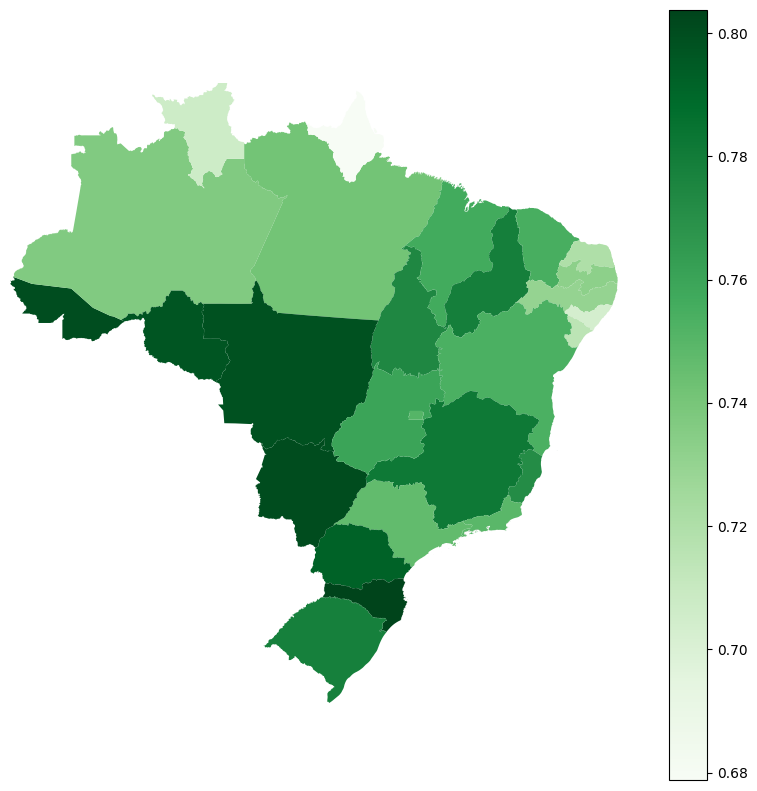

In [ ]:
proporcao_bons_pagadores = df_train[df_train['TARGET'] == 0].groupby('VAR5').size() / df_train.groupby('VAR5').size()

estados['proporcao_bons_pagadores'] = estados['SIGLA_UF'].map(proporcao_bons_pagadores).fillna(0)

fig, ax = plt.subplots(figsize=(10, 10))
estados.plot(ax=ax, column='proporcao_bons_pagadores', cmap='Greens', legend=True)
ax.set_xlim([-74, -34])
ax.set_ylim([-34, 5])
ax.axis('off')
plt.show()

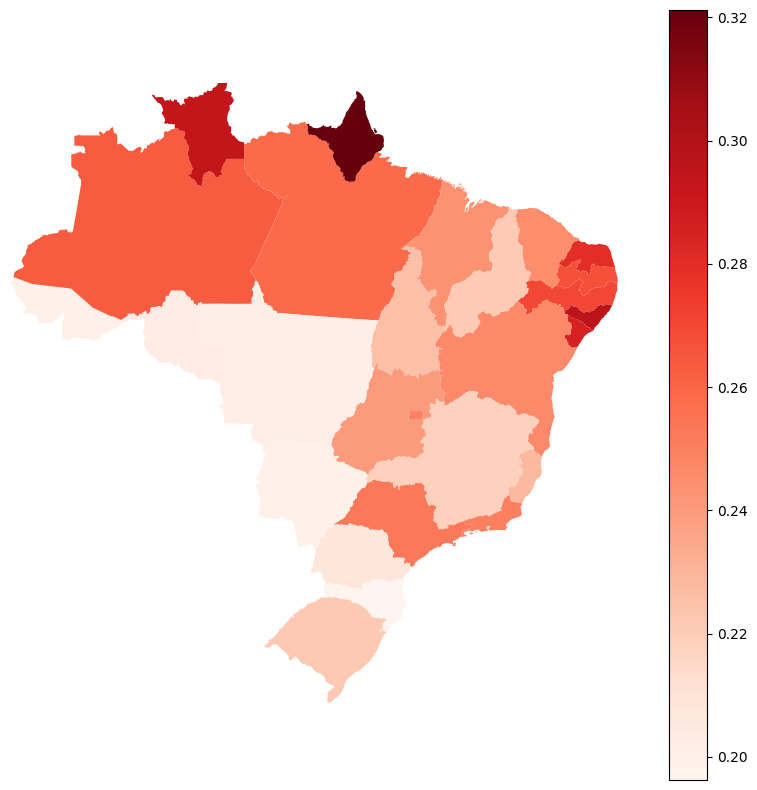

In [ ]:
proporcao_maus_pagadores = df_train[df_train['TARGET'] == 1].groupby('VAR5').size() / df_train.groupby('VAR5').size()

estados['proporcao_maus_pagadores'] = estados['SIGLA_UF'].map(proporcao_maus_pagadores).fillna(0)

fig, ax = plt.subplots(figsize=(10, 10))
estados.plot(ax=ax, column='proporcao_maus_pagadores', cmap='Reds', legend=True)
ax.set_xlim([-74, -34])
ax.set_ylim([-34, 5])
ax.axis('off')
plt.show()

<ipython-input-19-08a4cc4e52a7>:3: FutureWarning: The default value of numeric_only in aggfunc='mean' within pandas.DataFrameGroupBy.agg used in dissolve is deprecated. In pandas 2.0, numeric_only will default to False. Either specify numeric_only as additional argument in dissolve() or select only columns which should be valid for the function.
  regioes = estados.dissolve(by='NM_REGIAO', aggfunc='mean')


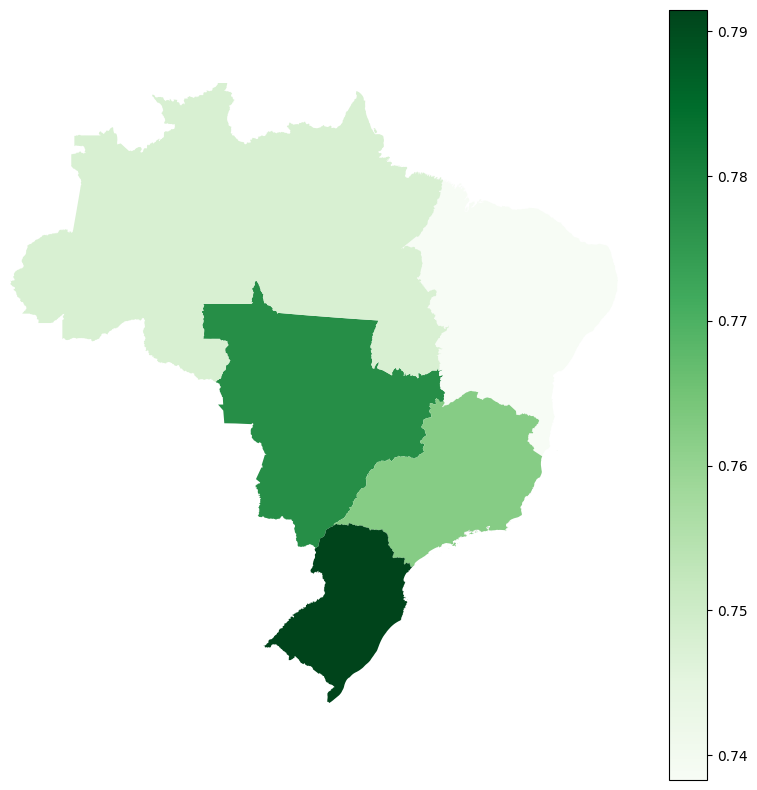

In [ ]:
proporcao_bons_pagadores_por_regiao = df_train[df_train['TARGET'] == 0].groupby('VAR5').size() / df_train.groupby('VAR5').size()
estados['proporcao_bons_pagadores'] = estados['SIGLA_UF'].map(proporcao_bons_pagadores_por_regiao).fillna(0)
regioes = estados.dissolve(by='NM_REGIAO', aggfunc='mean')

fig, ax = plt.subplots(figsize=(10, 10))
regioes.plot(ax=ax, column='proporcao_bons_pagadores', cmap='Greens', legend=True)
ax.set_xlim([-74, -34])
ax.set_ylim([-34, 5])

ax.axis('off')
plt.show()


<ipython-input-20-ca80fa5d9393>:3: FutureWarning: The default value of numeric_only in aggfunc='mean' within pandas.DataFrameGroupBy.agg used in dissolve is deprecated. In pandas 2.0, numeric_only will default to False. Either specify numeric_only as additional argument in dissolve() or select only columns which should be valid for the function.
  regioes = estados.dissolve(by='NM_REGIAO', aggfunc='mean')


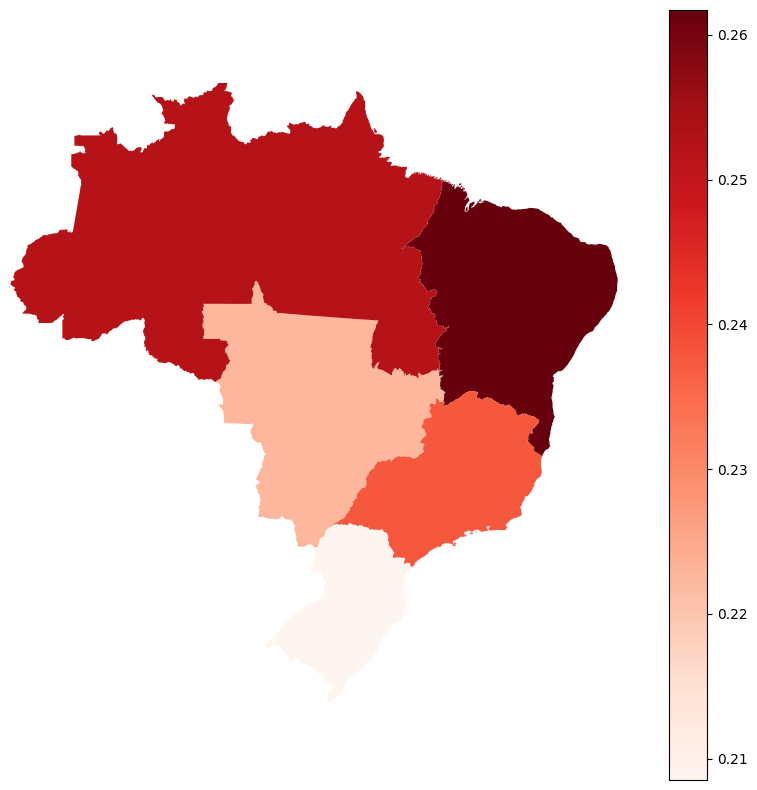

In [ ]:
proporcao_maus_pagadores_por_regiao = df_train[df_train['TARGET'] == 1].groupby('VAR5').size() / df_train.groupby('VAR5').size()
estados['proporcao_maus_pagadores'] = estados['SIGLA_UF'].map(proporcao_maus_pagadores_por_regiao).fillna(0)
regioes = estados.dissolve(by='NM_REGIAO', aggfunc='mean')

fig, ax = plt.subplots(figsize=(10, 10))
regioes.plot(ax=ax, column='proporcao_maus_pagadores', cmap='Reds', legend=True)
ax.set_xlim([-74, -34])
ax.set_ylim([-34, 5])

ax.axis('off')
plt.show()


É importante notar que não existe uma concentração muito evidente de bons ou maus pagadores em um estado especificamente, isso pode ser bom para não enviesar nas predições.

## Correlação dos dados

In [ ]:
matriz_correlacao = df_train.corr()
mascara = np.abs(matriz_correlacao) <= 0.5

<ipython-input-21-b3165f8c021e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacao = df_train.corr()


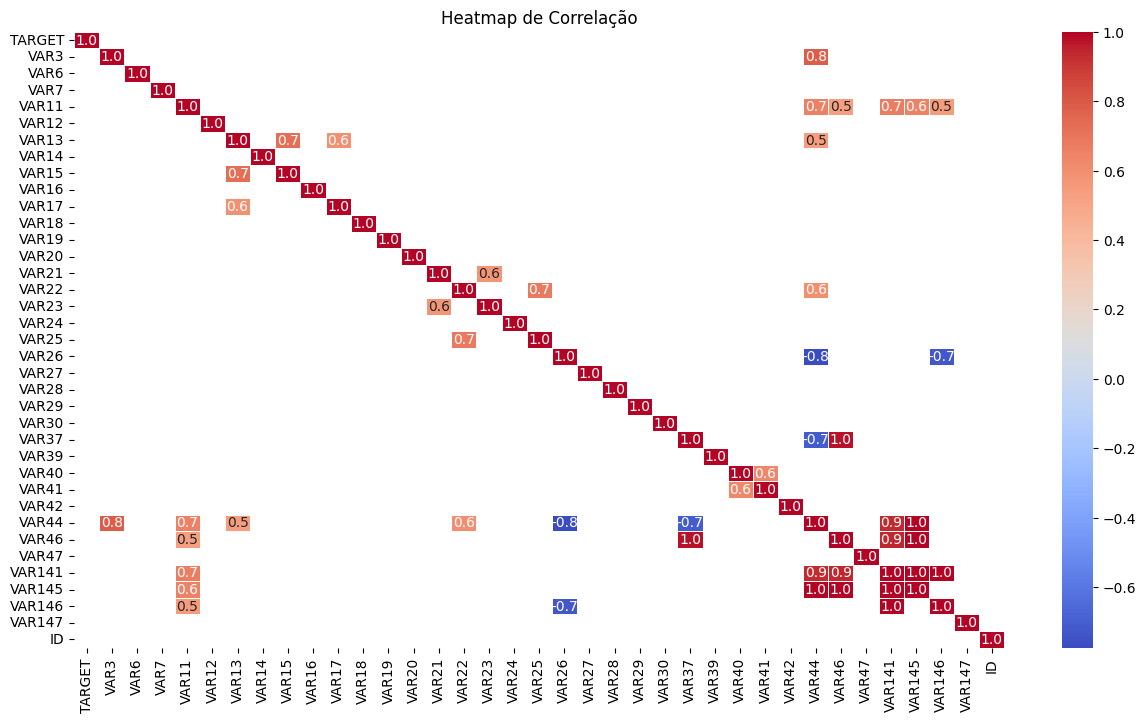

In [ ]:
plt.figure(figsize=(15, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.1f', linewidths=.5, mask=mascara)
plt.title('Heatmap de Correlação')
plt.show()

In [ ]:
mascara = np.zeros_like(matriz_correlacao, dtype=bool)
np.fill_diagonal(mascara, True)
mascara |= np.abs(matriz_correlacao) < 0.5

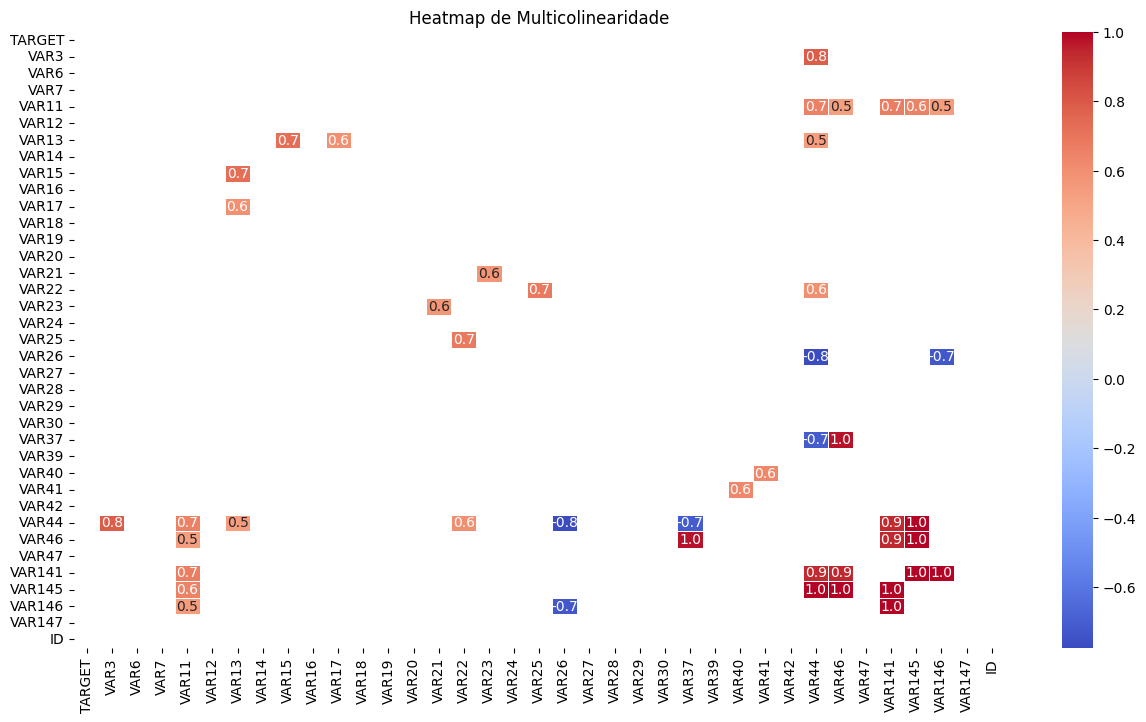

In [ ]:
plt.figure(figsize=(15, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.1f', linewidths=.5, mask=mascara)
plt.title('Heatmap de Multicolinearidade')
plt.show()

# Pré processamento

## Downsampling

In [ ]:
df_train.TARGET.value_counts()

0    91163
1    29587
Name: TARGET, dtype: int64

In [ ]:
df_majority = df_train[df_train.TARGET == 0]
df_minority = df_train[df_train.TARGET == 1]

In [ ]:
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=123)

In [ ]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [ ]:
df_downsampled = df_downsampled.sample(frac=1, random_state=123).reset_index(drop=True)

In [ ]:
df_downsampled.TARGET.value_counts()

0    29587
1    29587
Name: TARGET, dtype: int64

In [ ]:
X_train = df_downsampled
y_train = df_downsampled.TARGET.to_numpy()

In [ ]:
X_test = df_test
y_test = df_test.TARGET.to_numpy()

X_oot = df_oot

## Tratamento de nulos, One-hot-encode e Normalização

In [ ]:
colunas_numericas = colunas_numericas_a_utilizar
colunas_categoricas = colunas_categoricas_a_utilizar

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, colunas_numericas),
        ('cat', categorical_transformer, colunas_categoricas)
    ])

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [ ]:
processed_data_train = pipeline.fit_transform(X_train[colunas_numericas + colunas_categoricas])
processed_data_train = pd.DataFrame.sparse.from_spmatrix(processed_data_train)
processed_data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565
0,-1.632031e+00,-1.051796e+00,-1.408266e-01,0.000000,0.000000,6.529853e-16,-9.032115e-01,0.000000,-2.380738e-16,5.940915e-16,-3.038010e-01,-2.960966e-16,-0.647883,1.534088e-16,-3.746436e-17,-1.027648e-15,-7.432996e-16,2.431426,-1.465639,-0.592780,0.443006,0.0,-0.625421,0.080408,0.284433,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0

In [ ]:
processed_data_test = pipeline.transform(X_test.drop("TARGET",axis=1)[colunas_numericas + colunas_categoricas])
processed_data_test = pd.DataFrame.sparse.from_spmatrix(processed_data_test)
processed_data_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565
0,1.443929e+00,0.185396,0.915953,0.000000,1.020975,6.529853e-16,-7.272193e-01,0.000000,-2.380738e-16,5.940915e-16,4.912054e-01,-2.960966e-16,-0.647883,1.534088e-16,-3.746436e-17,-1.027648e-15,-7.432996e-16,1.749498,-0.292326,0.977984,1.009743,0.0,-0.627881,0.564601,0.284433,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.

In [ ]:
processed_data_oot = pipeline.transform(X_oot[colunas_numericas + colunas_categoricas])
processed_data_oot = pd.DataFrame.sparse.from_spmatrix(processed_data_oot)
processed_data_oot.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565
0,0.696583,-7.875880e-01,-5.239582e-01,0.000000,0.000000,6.529853e-16,2.171006e-16,0.000000,-2.380738e-16,5.940915e-16,2.577291e-16,-2.960966e-16,0.000000,1.534088e-16,-3.746436e-17,-1.027648e-15,-7.432996e-16,1.166276,-0.123506,1.381809,0.465403,0.0,-0.625421,0.144546,0.284433,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.

## Feature selection

In [ ]:
selector = SelectFromModel(XGBClassifier(n_estimators=500))
processed_train_data_selected = selector.fit_transform(processed_data_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


In [ ]:
X_train = pd.DataFrame.sparse.from_spmatrix(processed_train_data_selected)
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374
0,-1.632031e+00,-1.051796e+00,-1.408266e-01,0.000000,0.000000,6.529853e-16,-9.032115e-01,0.000000,-2.380738e-16,5.940915e-16,-3.038010e-01,-2.960966e-16,-0.647883,1.534088e-16,-3.746436e-17,-7.432996e-16,2.431426,-1.465639,-0.592780,0.443006,0.0,-0.625421,0.080408,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-7.211768e-01,-9.972612e-01,-1.607028e-01,-0.468244,0.000000,6.529853e-16,-5.903365e-01,-0.677812,-2.380738e-16,5.940915e-16,5.230065e-01,-3.151133e-02,-0.506943,-7.146866e-01,-3.746436e-17,-7.432996e-16,-0.478602,-0.712308,-0.636919,-0.746689,0.0,-0.536887,-0.367633,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.

In [ ]:
processed_test_data_selected = selector.transform(processed_data_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


In [ ]:
X_test = pd.DataFrame.sparse.from_spmatrix(processed_test_data_selected)
X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374
0,1.443929e+00,1.853958e-01,9.159529e-01,0.000000,1.020975,6.529853e-16,-7.272193e-01,0.000000,-2.380738e-16,5.940915e-16,4.912054e-01,-2.960966e-16,-0.647883,1.534088e-16,-3.746436e-17,-7.432996e-16,1.749498,-0.292326,0.977984,1.009743,0.0,-0.627881,0.564601,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,-8.921305e-01,7.204375e-01,1.347791e+00,-0.468244,0.000000,6.529853e-16,-5.355834e-01,-0.407152,-2.380738e-16,5.940915e-16,1.795621e-01,-1.160701e+00,0.496215,3.840690e-03,-3.746436e-17,-7.432996e-16,-0.777187,-0.149647,1.387712,0.064070,0.0,-0.627881,-0.442660,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0

In [ ]:
processed_oot_data_selected = selector.transform(processed_data_oot)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


In [ ]:
X_oot = pd.DataFrame.sparse.from_spmatrix(processed_oot_data_selected)
X_oot

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374
0,0.696583,-7.875880e-01,-5.239582e-01,0.000000,0.000000,6.529853e-16,2.171006e-16,0.000000,-2.380738e-16,5.940915e-16,2.577291e-16,-2.960966e-16,0.000000,1.534088e-16,-3.746436e-17,-7.432996e-16,1.166276,-0.123506,1.381809,0.465403,0.0,-0.625421,0.144546,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.799892,-6.794965e-01,-6.440686e-01,0.000000,1.707718,6.529853e-16,-3.713241e-01,0.000000,-4.488584e-01,5.940915e-16,-5.645635e-01,-2.960966e-16,-0.216774,1.534088e-16,-3.746436e-17,5.270661e-01,0.597543,-0.339710,-0.782659,4.644004,0.0,1.831418,-0.089980,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.

# Treinamento

In [ ]:
xgb = XGBClassifier()

xgb.fit(
    X=X_train,
    y=y_train,
    verbose=0
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_test_pred = xgb.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, y_test_pred)
auc_roc_test

0.6943799404013095

# Otimização de hiperparâmetros

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
xgb = XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 8, 10],
}

grid = ParameterGrid(param_grid)

best_score = 0
best_params = None

for params in tqdm(grid):
    xgb.set_params(**params)
    xgb.fit(X_train, y_train)

    y_test_pred = xgb.predict_proba(X_test)[:, 1]
    auc_roc_test = roc_auc_score(y_test, y_test_pred)

    if auc_roc_test > best_score:
        best_score = auc_roc_test
        best_params = params

print("\n")
print("Melhores parâmetros:", best_params)
print("Melhor AUC-ROC no conjunto de teste:", best_score)

100%|██████████| 125/125 [16:41<00:00,  8.01s/it]



Melhores parâmetros: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}
Melhor AUC-ROC no conjunto de teste: 0.7066640015221016


# Análise técnica

In [ ]:
xgb_best = XGBClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators']
)
xgb_best.fit(X_train, y_train)

y_train_pred = xgb_best.predict_proba(X_train)[:, 1]
auc_roc_train = roc_auc_score(y_train, y_train_pred)

y_test_pred = xgb_best.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, y_test_pred)

print(auc_roc_train)
print(auc_roc_test)

0.7957279677981086
0.7066640015221016


## AUC - ROC

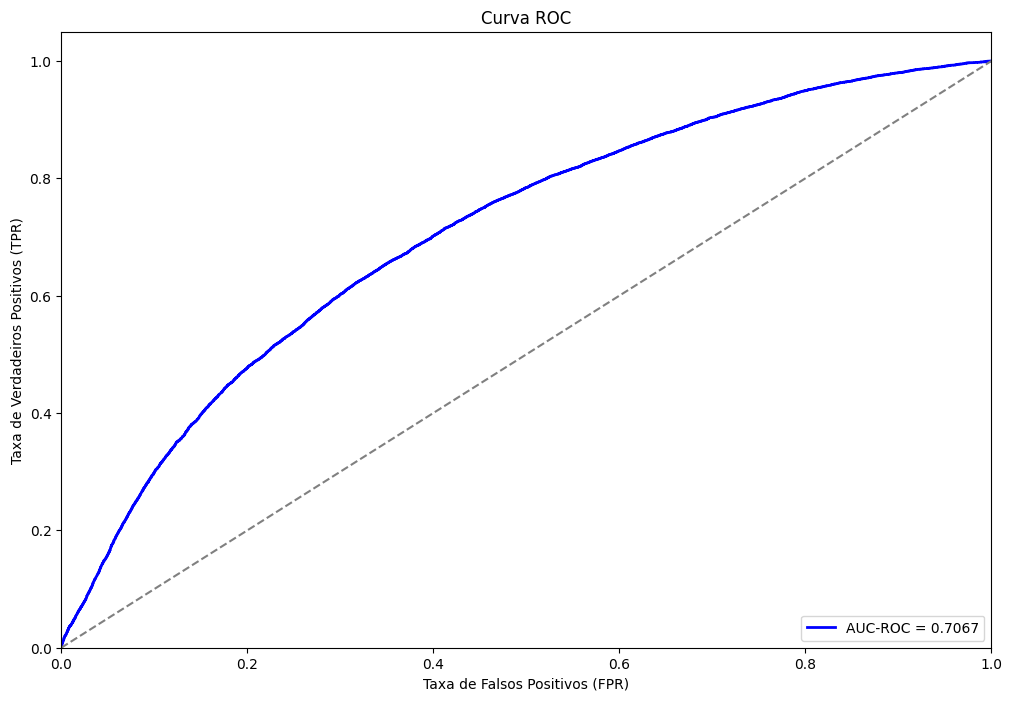

In [ ]:
y_test_prob = xgb_best.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC-ROC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

## Matriz de confusão

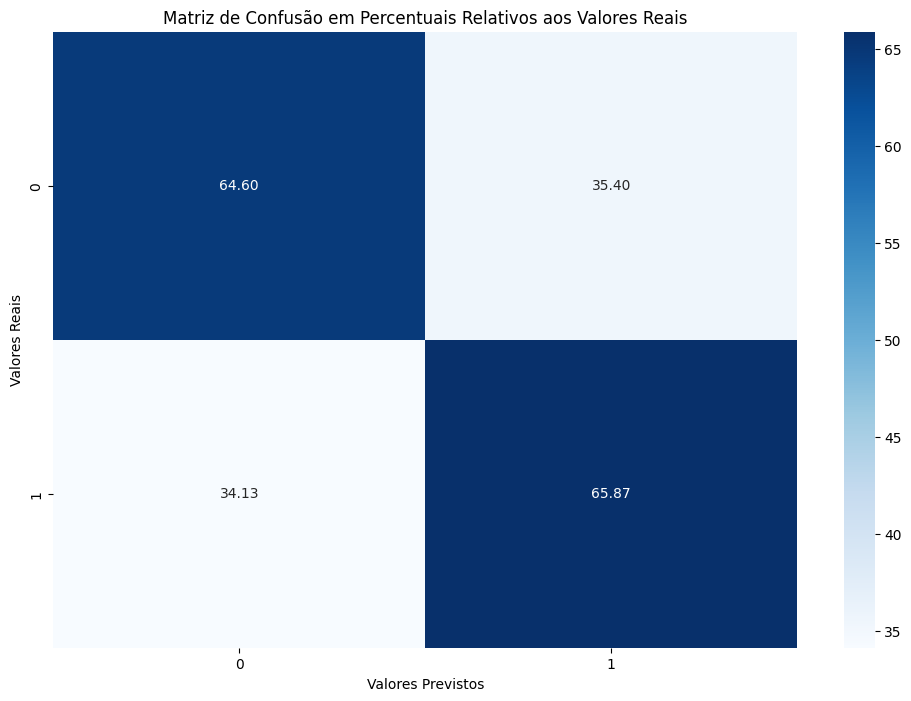

In [ ]:
y_test_pred = xgb_best.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix_percent_relative = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_percent_relative, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão em Percentuais Relativos aos Valores Reais')
plt.show()

# Análise financeira

1.  Filtrar os dados para o mês de agosto de 2017: Isso envolve selecionar apenas as linhas cuja coluna REF_DATE indique uma data em agosto de 2017.

2. Política AS-IS (baseada na idade):

  * Calcular o tamanho da carteira de crédito aprovado: Somar o valor dos empréstimos de R$1000,00 para cada pessoa com idade superior a 28 anos.
  * Calcular a dívida total: Considerar a inadimplência (caso seja fornecida alguma taxa ou critério de inadimplência).
Cálculo do percentual de solicitações negadas na Política AS-IS: Determinar o percentual de pessoas com idade igual ou inferior a 28 anos em relação ao total.

3. Política TO-BE (baseada no score):

  * Determinar o ponto de corte do score: Este ponto de corte deve resultar no mesmo percentual de solicitações negadas obtido na Política AS-IS.
  * Calcular o novo tamanho da carteira de crédito aprovado e a dívida total.

In [ ]:
y_test_proba = xgb_best.predict_proba(X_test)

In [ ]:
df_test['proba_bom_pagador_label_0'] = y_test_proba[:,0]

In [ ]:
df_analise_financeira = df_test[['ID','REF_DATE','VAR3','proba_bom_pagador_label_0']]
df_analise_financeira

,ID,REF_DATE,VAR3,proba_bom_pagador_label_0
0,8396,2017-01-04 00:00:00+00:00,61.532,0.713382
1,74636,2017-08-22 00:00:00+00:00,28.586,0.530508
2,95855,2017-01-04 00:00:00+00:00,NaN,0.325952
3,120857,2017-01-09 00:00:00+00:00,NaN,0.354617
4,126978,2017-05-11 00:00:00+00:00,24.288,0.352317
...,...,...,...,...
51746,92929,2017-01-02 00:00:00+00:00,NaN,0.541889
51747,6490,2017-06-07 00:00:00+00:00,22.099,0.465511
51748,41927,2017-08-02 00:00:00+00:00,59.753,0.803359
51749,101573,2017-06-08 00:00:00+00:00,20.340,0.494305


In [ ]:
df_analise_financeira['REF_DATE'] = pd.to_datetime(df_analise_financeira['REF_DATE'])
df_agosto = df_analise_financeira[df_analise_financeira['REF_DATE'].dt.month == 8]
total_pessoas = df_agosto.shape[0]

<ipython-input-54-ba3e91ca1180>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analise_financeira['REF_DATE'] = pd.to_datetime(df_analise_financeira['REF_DATE'])


In [ ]:
# Política AS-IS
# Tamanho da carteira de crédito aprovado e percentual de pessoas negadas
carteira_as_is = df_agosto[df_agosto['VAR3'] > 28].shape[0] * 1000
pessoas_negadas_as_is = df_agosto[df_agosto['VAR3'] <= 28].shape[0]
percentual_negadas_as_is = (pessoas_negadas_as_is / total_pessoas) * 100

In [ ]:
# Política TO-BE
# Ponto de corte do score
ponto_corte = df_agosto['proba_bom_pagador_label_0'].quantile(0.5)
carteira_to_be = df_agosto[df_agosto['proba_bom_pagador_label_0'] >= ponto_corte].shape[0] * 1000

In [ ]:
print(f"Tamanho da Carteira de Crédito Aprovado (AS-IS): R${carteira_as_is}")
print(f"Tamanho da Carteira de Crédito Aprovado (TO-BE): R${carteira_to_be}")
print("\n")
print(f"Ponto de Corte do Score (TO-BE): {ponto_corte}")
print("\n")
print(f"Percentual de Pessoas Negadas (AS-IS): {percentual_negadas_as_is}%")

Tamanho da Carteira de Crédito Aprovado (AS-IS): R$5432000
Tamanho da Carteira de Crédito Aprovado (TO-BE): R$3653000


Ponto de Corte do Score (TO-BE): 0.5928357839584351


Percentual de Pessoas Negadas (AS-IS): 18.781656399726216%


# Escoragem da base Out-of-time

In [ ]:
y_oot_pred = xgb_best.predict(X_oot)
y_oot_proba = xgb_best.predict_proba(X_oot)

In [ ]:
df_oot['TARGET'] = y_oot_pred
df_oot['proba_bom_pagador_label_0'] = y_oot_proba[:,0]
df_oot['proba_mau_pagador_label_1'] = y_oot_proba[:,1]

In [ ]:
df_oot = df_oot[['ID','TARGET','proba_bom_pagador_label_0','proba_mau_pagador_label_1']]
df_oot.head()

,ID,TARGET,proba_bom_pagador_label_0,proba_mau_pagador_label_1
0,61900,1,0.454969,0.545031
1,300199,0,0.732929,0.267071
2,45656,0,0.804951,0.195049
3,153386,1,0.477663,0.522337
4,321676,0,0.797648,0.202352


In [ ]:
df_oot.TARGET.value_counts()

0    61700
1    30265
Name: TARGET, dtype: int64

In [ ]:
df_oot.to_csv('/content/drive/MyDrive/Neurotech - Cientista de Dados III/challenge-data-scientist/datasets/credit_01/df_oot_with_target.csv', index=False)